## Using the RocketClassifier from the "aeon" package

The "aeon" is a time series classification library
https://www.aeon-toolkit.org/en/stable/examples/classification/classification.html

RocketClassifier is a convolutional neural network based method to do time series classification problem. 

(This notebook used the "neurokit2" and "aeon" packages. To successfully run the notebook, one needs to install these two packages first.) 

### 1. Load and Explore a CSV file


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import neurokit2 as nk



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss



In [3]:
participant_codes = ['3B8D','03FH','3RFH','4JF9','93DK','93JD','AP3H','F408',
                     'H39D','JD3K','K2Q2','KF93','KS03','LAS2','LDM5','LK27','ME93']

# the index-5 participant '93JD' do not contain all features
# the index-16 participant 'ME93' do not contain all features it has "featues_used"
# we will discard these two participants in the following list

selected_participants = ['3B8D','03FH','3RFH','4JF9','93DK','AP3H','F408',
                     'H39D','JD3K','K2Q2','KF93','KS03','LAS2','LDM5','LK27']

In [4]:
features_ISST = ['ecg:dry', 'ecg:gel', 'eda:gel', 'emg:Left Bicep',
                 'ppg:Left index finger', 'acc_chest:x', 'acc_chest:y', 'acc_chest:z']
features_E4 = ['eda:dry', 'temp:temp', 'ppg:Left Wrist', 'acc_e4:x', 'acc_e4:y', 'acc_e4:z']
# there are in total 14 features


features_combined = features_ISST + features_E4


#features_used = ['ecg:dry', 'ecg:gel', 'eda:dry', 'eda:gel', 'emg:Left Bicep', 'temp:temp',
# 'ppg:Left index finger', 'ppg:Left Wrist', 'acc_e4:z', 'acc_e4:x', 'acc_e4:y',
# 'acc_chest:x', 'acc_chest:y', 'acc_chest:z']

features_used = ['ecg:dry', 'eda:dry','acc_e4:z', 'acc_e4:x', 'acc_e4:y',
 'acc_chest:x', 'acc_chest:y', 'acc_chest:z' ]

columns_used = features_used + ['activities']

In [5]:
#encoding the eight different activities with numbers 1-8. Note that the slightly different descriptions

activity_encoder = {'baseline,':1,'lift,':2,'lift-1,':2, 'lift-2,':2,
                    'greetings,':3, 
                    'gesticulate,':4, 'jumps,':5, 
                    'walk_before,':6,'walk_before_downstairs,':6,'walk_before_elevatorup,':6,'walk_before_elevatordown,':6,
                    'run,':7, 'sprint,run,':7,
                    'walk_after,':8, 'run,walk_after':8, 'run,walk_after,':8}

In [6]:
# the data is taken with frequence 500 Hz, which means 500 data points in a sequence represents 1 second in time. 
# One can adjust the segmentation window to cut the time series, for example, 10 seconds, 20 seconds....

n_timepoints = 500*10
n_channels = len(features_used)


#motions variable records the input as a 3d array with the element being a time series.

motions = np.empty([1,n_channels,n_timepoints])
motions_labels = []

In [7]:
#read data from each participant's .csv file.

for code in selected_participants: 
    signals = pd.read_csv(f'csv/{code}.csv', index_col=0, parse_dates=True, low_memory=False)
    
    signals_copy  = signals[columns_used].copy()
    signals_copy.dropna(inplace=True)
    all_columns = signals_copy.columns.values
    #print("the features are: ", all_columns)
    all_channels = all_columns[:-1]
    
    signals_copy['activities'] = signals_copy['activities'].replace(activity_encoder)
    signals_copy['activities'] = pd.to_numeric(signals_copy['activities'])
    activity_num=signals_copy['activities'].unique()
    
    for k in range(1,9):
        if k in signals_copy['activities'].unique():
            change_row = signals_copy.loc[signals_copy['activities']==k].index[0]
            signals_copy.loc[change_row, 'activities']=0
    
    events = nk.events_find(event_channel=signals_copy['activities'], 
                        threshold = 0,
                        threshold_keep='above', 
                        event_conditions=activity_num)
    
    for i in range(len(events['onset'])):
        itr = events['duration'][i]//n_timepoints
        j=1
        while j<= itr:
            collect_channels = np.empty([1, n_timepoints])
            for l in range(n_channels):
                new_ts = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:][all_channels[l]].values
                new_ts = new_ts.reshape(1, -1)
                collect_channels = np.concatenate((collect_channels, new_ts))
            
            collect_channels = np.delete(collect_channels, (0), axis = 0)
            collect_channels= collect_channels.reshape((1,n_channels, n_timepoints))
        #print("new_ts size: ", new_ts.shape)
        #print("motions size: ", motions.shape)
            motions = np.concatenate((motions, collect_channels))
            motions_labels.append(events['condition'][i])
            j = j+1
    print(f"Finished extracting data from participant {code}.")
    
motions = np.delete(motions, (0), axis = 0)
motions_labels = np.array(motions_labels)
print("finish extracting all data. ")

Finished extracting data from participant 3B8D.
Finished extracting data from participant 03FH.
Finished extracting data from participant 3RFH.
Finished extracting data from participant 4JF9.
Finished extracting data from participant 93DK.
Finished extracting data from participant AP3H.
Finished extracting data from participant F408.
Finished extracting data from participant H39D.
Finished extracting data from participant JD3K.
Finished extracting data from participant K2Q2.
Finished extracting data from participant KF93.
Finished extracting data from participant KS03.
Finished extracting data from participant LAS2.
Finished extracting data from participant LDM5.
Finished extracting data from participant LK27.
finish extracting all data. 


In [8]:
print("input shape: ", motions.shape)
print("output labels: ",motions_labels.shape)

input shape:  (3048, 8, 5000)
output labels:  (3048,)


In [9]:
all_motions = ['baseline','lift',
                    'greetings', 
                    'gesticulate', 'jumps', 
                    'walk_before',
                    'run',
                    'walk_after']

In [10]:
unique_values, counts = np.unique(motions_labels, return_counts=True)

count_motions = pd.DataFrame({  'activities': all_motions,"counts": counts, "codes":unique_values})
count_motions


,activities,counts,codes
0,baseline,56,1
1,lift,95,2
2,greetings,58,3
3,gesticulate,144,4
4,jumps,12,5
5,walk_before,258,6
6,run,2198,7
7,walk_after,227,8


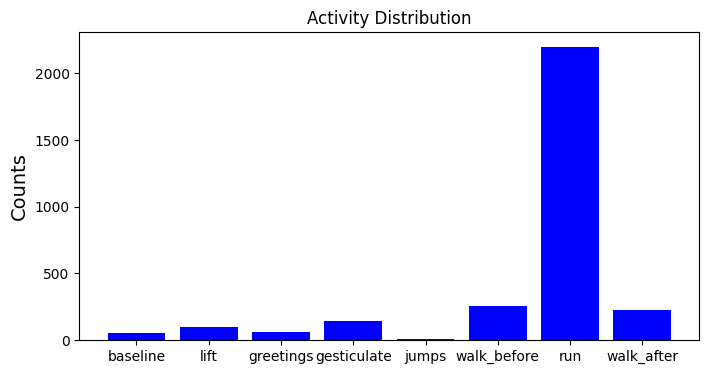

In [11]:
plt.figure(figsize = (8, 4))
plt.bar(count_motions['activities'], height = count_motions['counts'], color = 'blue')
#plt.xlabel("Activities", fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title("Activity Distribution")
plt.savefig("activity_counts.png")
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(motions, motions_labels, 
                                                    test_size = 0.2, stratify = motions_labels, shuffle=True, random_state = 127)

print("X_train shape ", X_train.shape)
print("X_test shape ", X_test.shape)
print("y_train shape ", y_train.shape)
print("y_test shape ", y_test.shape)

X_train shape  (2438, 8, 5000)
X_test shape  (610, 8, 5000)
y_train shape  (2438,)
y_test shape  (610,)


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [14]:
from aeon.classification.convolution_based import RocketClassifier


In [15]:
#the num_kernels is the only adjust parameter here. For "minirocket", 10000 kernels reuslt in 10000 features
rocket = RocketClassifier(rocket_transform="minirocket",num_kernels=10000, n_jobs=-1, random_state=127)

ti = time.time()
rocket.fit(X_train, y_train)
tf = time.time()

y_pred_rocket = rocket.predict(X_test)
y_pred_prob_rocket = rocket.predict_proba(X_test)


print("totoal training&predicting time in seconds: ", tf - ti)


print("the accuracy score using RocketClassifier: ", accuracy_score(y_test, y_pred_rocket))
print("the log loss using RocketClassifier: ", log_loss(y_test, y_pred_prob_rocket))

totoal training&predicting time in seconds:  45.93755793571472
the accuracy score using RocketClassifier:  0.9836065573770492
the log loss using RocketClassifier:  0.5908795637560205


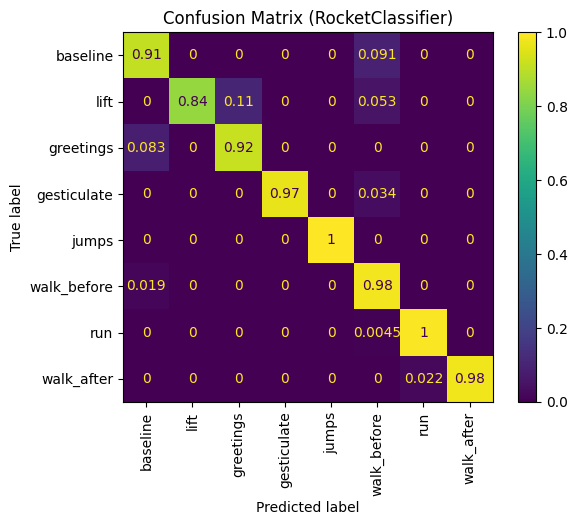

In [16]:
cmp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_rocket,display_labels = all_motions,normalize='true', xticks_rotation='vertical')
plt.title("Confusion Matrix (RocketClassifier)")
plt.savefig("CM_Rocket.png")
plt.show()

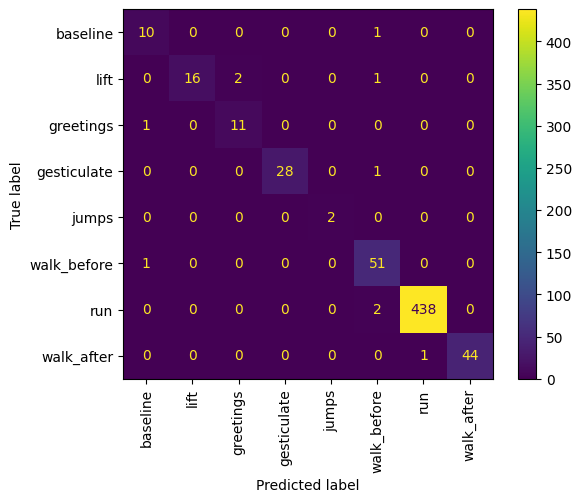

In [17]:
cmp_unnormalized = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_rocket,display_labels = all_motions, xticks_rotation='vertical')


## Summary

We only used the "ecg", "eda" and "acc" signals to predict human activities. The convolutional neural network based method does a very good job in making predictions especially for the "jump" activity. 

________
©  All rights reserved.

Notebook offered by the Dr. Ming Li.
Contact: li.13449@osu.edu